Preparing and loading training data...


100%|██████████| 340/340 [02:03<00:00,  2.75it/s]


Done Preparing training data...
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                        

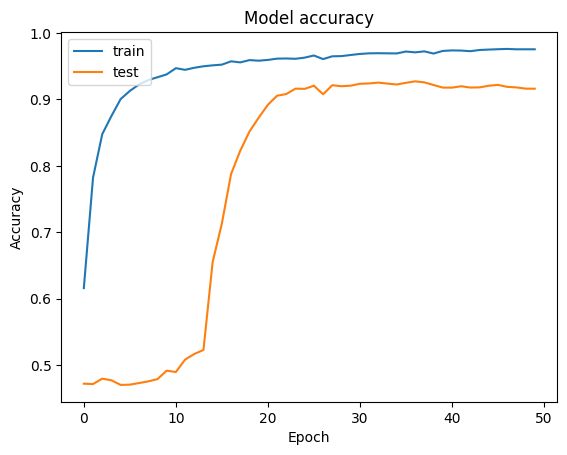

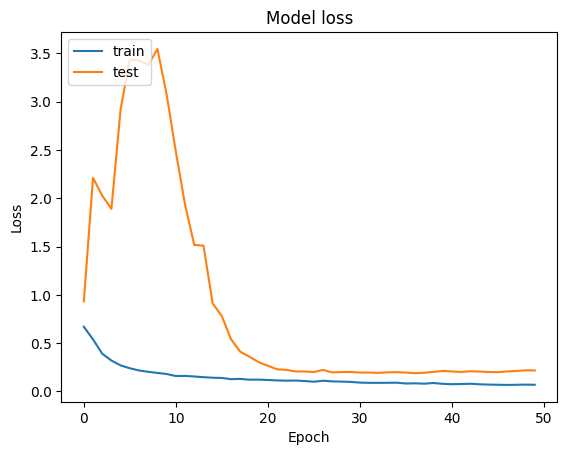

Preparing testing data...


100%|██████████| 320/320 [03:47<00:00,  1.40it/s]


64/64 [==============================] - 6s 64ms/step
Calculating metrics...


Calculating y_test: 100%|██████████| 320/320 [00:17<00:00, 18.62it/s]


              precision    recall  f1-score   support

         0.0       0.85      0.83      0.84   9903630
         1.0       0.85      0.87      0.86  11067890

    accuracy                           0.85  20971520
   macro avg       0.85      0.85      0.85  20971520
weighted avg       0.85      0.85      0.85  20971520

mIoU: 0.7433038798185085


100%|██████████| 320/320 [00:41<00:00,  7.65it/s]


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dropout, UpSampling2D, Input,
    BatchNormalization, Activation, Concatenate, Reshape, Dense,
    AveragePooling2D, GlobalAveragePooling2D,
)
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from keras.models import Model
from keras.applications import ResNet50, ResNet101
from keras.regularizers import l2

def lab_split(I):
    I = cv2.cvtColor(I, cv2.COLOR_BGR2LAB)
    I = I.astype(np.float32)
    I1, I2, I3 = cv2.split(I)
    I1 /= 2.55
    I2 -= 128.0
    I3 -= 128.0
    return I1, I2, I3

def merge_back(I1, I2, I3):
    I1 *= 2.55
    I2 += 128.0
    I3 += 128.0
    I = np.clip(cv2.merge((I1, I2, I3)), 0, 255).astype(np.uint8)
    return cv2.cvtColor(I, cv2.COLOR_LAB2BGR)

def get_mean_std(I):
    I1, I2, I3 = lab_split(I)
    m1, sd1 = cv2.meanStdDev(I1)
    m2, sd2 = cv2.meanStdDev(I2)
    m3, sd3 = cv2.meanStdDev(I3)
    means = m1, m2, m3
    stds = sd1, sd2, sd3
    return means, stds

def Reinhard_method(target,I):
    means, stds = get_mean_std(target)
    target_means = means
    target_stds = stds
    I1, I2, I3 = lab_split(I)
    means, stds = get_mean_std(I)
    norm1 = ((I1 - means[0]) * (target_stds[0] / stds[0])) + target_means[0]
    norm2 = ((I2 - means[1]) * (target_stds[1] / stds[1])) + target_means[1]
    norm3 = ((I3 - means[2]) * (target_stds[2] / stds[2])) + target_means[2]
    return merge_back(norm1, norm2, norm3)

def calculateClass(img,n_labels,h,w):
    lab=np.zeros([h,w])
    for i in range (h):
        for j in range (w):
            b=img[i][j][0]
            g=img[i][j][1]
            r=img[i][j][2]
            if b==229 and g==155 and r==3:
                lab[i][j]=0
            else:
                lab[i][j]=1
    return lab

def create_label(img, dims,h,w,n_labels=2):
    labels=calculateClass(img,n_labels,h,w)
    x1 = np.zeros([dims[0], dims[1], n_labels])
    for i in range(dims[0]):
        for j in range(dims[1]):
            v1=int(labels[i][j])
            x1[i][j][v1]=1
    x1 = x1.reshape(dims[0] , dims[1], n_labels)
    return x1

def Calculate_metrics(test_image, gt, h, w):
    size = len(test_image)
    h, w, b1 = np.shape(test_image[0])

    y_pred = np.zeros((h * w * size, 1))
    y_test = np.zeros((h * w * size, 1))

    res_img = []

    for q in tqdm(range(size), desc="Processing images"):
        img11 = test_image[q]
        img = np.zeros((h, w, 3))
        for i in range(h):
            for j in range(w):
                c1 = img11[i][j][0]
                c2 = img11[i][j][1]
                if c1 > c2:
                    img[i][j] = [0, 0, 0]
                else:
                    img[i][j] = [255, 255, 255]
        res_img.append(img)

    res_img = np.array(res_img)
    c = 0
    for i in tqdm(range(size), desc="Calculating y_pred"):
        img = res_img[i]
        for j in range(h):
            for l in range(w):
                b = img[j][l][0]
                if b == 0:
                    y_pred[c][0] = 0
                else:
                    y_pred[c][0] = 1
                c += 1

    c = 0
    for i in tqdm(range(size), desc="Calculating y_test"):
        img = gt[i]
        for j in range(h):
            for l in range(w):
                b = img[j][l][0]
                if b == 1:
                    y_test[c][0] = 0
                else:
                    y_test[c][0] = 1
                c += 1

    print(classification_report(y_test, y_pred))

    conf_mat = confusion_matrix(y_test, y_pred, labels=[0, 1])
    tp = np.diag(conf_mat)
    fp = np.sum(conf_mat, axis=0) - tp
    fn = np.sum(conf_mat, axis=1) - tp
    iou = tp / (tp + fp + fn + 1e-10)
    miou = np.mean(iou)

    print('mIoU:', miou)
    return

def dice_coef(y_true, y_pred):
    numerator = 2 * K.sum(y_true * y_pred, axis=(1, 2, 3))
    denominator = K.sum(y_true, axis=(1, 2, 3)) + K.sum(y_pred, axis=(1, 2, 3))
    dice_loss = 1 - (numerator + 1) / (denominator + 1)
    return dice_loss

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def Prepare_data(path_train, path_gt, h, w, n_labels=2):
    target = cv2.imread("/content/drive/MyDrive/Colab_Notebooks/BHI_dataset/Target.png")
    imgs = []
    labels = []

    files_train = os.listdir(path_train)
    files_gt = os.listdir(path_gt)

    base_files_train = set([os.path.splitext(file)[0] for file in files_train])
    base_files_gt = set([os.path.splitext(file)[0] for file in files_gt])

    matching_files = list(set(base_files_train).intersection(base_files_gt))

    for file_base in tqdm(matching_files):
        original_img = cv2.imread(os.path.join(path_train, file_base + ".png"))
        mask = cv2.imread(os.path.join(path_gt, file_base + ".png"))

        resized_img = cv2.resize(original_img, (h, w))
        cn_img = Reinhard_method(target, resized_img)
        array_img = img_to_array(cn_img) / 255
        imgs.append(array_img)

        mask = cv2.resize(mask, (h, w))
        array_mask = create_label(mask, (h, w),h,w,2)
        labels.append(array_mask)

    imgs = np.array(imgs)
    labels = np.array(labels)
    return imgs, labels, matching_files

def squeeze_and_excite(inputs: tf.Tensor, ratio: int = 8) -> tf.Tensor:
    """Function to apply Squeeze & Excitation to a feature map.

    Args:
        inputs (KerasTensor): Feature Map
        ratio (int, optional): Ratio for excitation in first dense layer. Defaults to 8.

    Returns:
        KerasTensor: Re-calibrated feature map.
    """
    init = inputs
    filters = init.shape[-1]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(
        filters // ratio,
        activation="relu",
        kernel_initializer="he_normal",
        use_bias=False,
    )(se)
    se = Dense(
        filters,
        activation="sigmoid",
        kernel_initializer="he_normal",
        use_bias=False,
    )(se)

    x = init * se
    return x

def ASPP(inputs: tf.Tensor) -> tf.Tensor:
    """Function to apply Atrous Spatial Pyramid Pooling on features from backbone.

    Args:
        inputs (KerasTensor): Features from backbone.

    Returns:
        KerasTensor: Features with better spatial context.
    """
    shape = inputs.shape
    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y1 = Conv2D(256, 1, padding="same", use_bias=False, kernel_initializer="he_normal")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    # 1x1 Convolution
    y2 = Conv2D(256, 1, padding="same", use_bias=False, kernel_initializer="he_normal")(inputs)
    y2 = BatchNormalization()(y2)
    # y2 = Dropout(0.5)(y2)
    y2 = Activation("relu")(y2)

    # 3x3 Convolution, Dilation Rate - 12 or 6
    y3 = Conv2D(
        256, 3, padding="same", dilation_rate=6, use_bias=False, kernel_initializer="he_normal"
    )(inputs)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    # 3x3 Convolution, Dilation Rate - 24 or 12
    y4 = Conv2D(
        256, 3, padding="same", dilation_rate=12, use_bias=False, kernel_initializer="he_normal"
    )(inputs)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    # 3x3 Convolution, Dilation Rate - 36 or 18
    y5 = Conv2D(
        256, 3, padding="same", dilation_rate=18, use_bias=False, kernel_initializer="he_normal"
    )(inputs)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    # 1x1 Convolution on the concatenated Feature Map
    y = Concatenate()([y1, y2, y3, y4, y5])
    y = Conv2D(256, 1, padding="same", use_bias=False, kernel_initializer="he_normal")(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def createModel(modelType: str, shape: tuple[int] = (256, 256, 3)) -> Model:
    """Creates a Model with the specified backbone.

    Args:
        modelType (str): Choice of backbone. ResNet50 or ResNet101.
        shape (tuple[int]): Shape of input to the model. Defaults to (256, 256, 3).

    Returns:
        Model: Your DeepLabV3+ Model.
    """
    inputs = Input(shape)  # instantiating a tensor

    encoder = (
        ResNet101(weights="imagenet", include_top=False, input_tensor=inputs)
        if modelType == "ResNet101"
        else ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)
    )

    image_features = encoder.get_layer(
        "conv4_block23_out" if modelType == "ResNet101" else "conv4_block6_out"
    ).output

    # High-Level Features
    x_a = ASPP(image_features)
    # Up-Sampling High-Level Features by 4
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)
    x_a = Dropout(0.5)(x_a)

    # Low-Level Features
    x_b = encoder.get_layer("conv2_block2_out").output

    # 1x1 Convolution on Low-Level Features
    x_b = Conv2D(
        filters=48, kernel_size=1, padding="same", use_bias=False, kernel_initializer="he_normal"
    )(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation("relu")(x_b)

    # Concatenating High-Level and Low-Level Features
    x = Concatenate()([x_a, x_b])
    x = Dropout(0.5)(x)
    # x = squeeze_and_excite(x)

    # 3x3 Convolution on Concatenated Map
    x = Conv2D(
        filters=256, kernel_size=3, padding="same", use_bias=False, kernel_initializer="he_normal"
    )(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = squeeze_and_excite(x)

    # 3x3 Convolution on Concatenated Map
    x = Conv2D(
        filters=256, kernel_size=3, padding="same", use_bias=False, kernel_initializer="he_normal"
    )(x)
    x = BatchNormalization()(x)
    # x = Dropout(0.5)(x)
    x = Activation("relu")(x)
    x = squeeze_and_excite(x)

    # Final Up-Sampling by 4
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)
    x = Conv2D(2, 1)(x)
    x = Activation("softmax")(x)

    model = Model(inputs, x)
    model.compile(optimizer=Adam(learning_rate=0.00001),loss="binary_crossentropy",metrics=["accuracy"])
    model.summary()
    return model

if __name__ == "__main__":
    path_train='/content/drive/MyDrive/Colab_Notebooks/BHI_dataset/Gt/'
    path_gt='/content/drive/MyDrive/Colab_Notebooks/BHI_dataset/Img/'

    h=256
    w=256

    print("Preparing and loading training data...")
    X,Y,filenames = Prepare_data(path_train,path_gt,h,w)
    print("Done Preparing training data...")

    nb_epoch = 50
    batch = 5
    n_labels = 2
    model=createModel("ResNet101")

    print('Model Compiled: OK.....')
    print("Opening model...")
    history=model.fit(x=X,y=Y,batch_size=batch, epochs=nb_epoch, verbose=1,validation_split=0.2)
    print("Model Fitting done...")
    model.save_weights('Deeplab_50.hdf5')
    model.load_weights('Deeplab_50.hdf5')

    fig=plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig.savefig("Deeplab_dice.png")
    # Summarize history for loss
    fig=plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig.savefig("Deeplab_loss.png")

    path_test_gt='/content/drive/MyDrive/Colab_Notebooks/BHI_dataset/Img-test/'
    path_test='/content/drive/MyDrive/Colab_Notebooks/BHI_dataset/Gt-test/'
    print("Preparing testing data...")
    test_data,gt,filenames = Prepare_data(path_test,path_test_gt,h,w)
    output = model.predict(test_data,batch_size=batch, verbose=1)

    print("Calculating metrics...")
    Calculate_metrics(output,gt,h,w)

    for i in tqdm(range(len(test_data))):
        Write_output_path = "/content/drive/MyDrive/Colab_Notebooks/BHI_dataset/DeepLab/Results/" + filenames[i] + ".png"
        out = output[i]
        img = test_data[i]
        for j in range(h):
            for p in range(w):
                if out[j][p][0] > out[j][p][1]:
                    img[j][p] = [0, 0, 0]
                else:
                    img[j][p] = [255, 255, 255]

        cv2.imwrite(Write_output_path, img)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
